<a href="https://colab.research.google.com/github/CShorten/Robust-Vector-Search/blob/main/CLIP_Classifier_and_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install clip-server > /dev/null
!pip install clip-client > /dev/null

In [ ]:
from clip_client import Client

c = Client("grpc://demo-cas.jina.ai:51000")

# test the single words for the labels
label_templates = [
                   "This is an image of an airplane.",
                   "This is an image of an automobile.",
                   "This is an image of a bird.",
                   "This is an image of a cat.",
                   "This is an image of a deer.",
                   "This is an image of a dog.",
                   "This is an image of a frog.",
                   "This is an image of a horse.",
                   "This is an image of a ship.",
                   "This is an image of a truck."
]
label_embeds = c.encode(label_templates)
label_embeds[0].shape

In [ ]:
!unzip cifar10_clip_embeds.zip

In [ ]:
!unzip train_images.zip

In [19]:
import numpy as np
import os
embed_dir = "train_embeds/"

total = 0
correct = 0

for path in os.listdir(embed_dir):
  img_embeds = np.load(embed_dir+path)
  distances = []
  for label_embed in label_embeds:
    distances.append(np.dot(img_embeds, label_embed))
  distances = np.array(distances)
  pred = np.argmax(distances)
  label = int(path.split("label-")[1].replace(".npy", ""))
  if pred == label:
    correct += 1
  total += 1

correct / total * 100

60.049976250955126

In [37]:
from docarray import DocumentArray, Document

training_embeds = DocumentArray()

for path in os.listdir(embed_dir):
  img_embeds = np.load(embed_dir+path)
  img_path = path.replace(".npy", ".jpg")
  full_img_path = "./train_images/"+img_path
  training_embeds.append(Document(embedding=img_embeds, uri=full_img_path))

In [38]:
training_embeds

╭──────────────────────── Documents Summary ─────────────────────────╮
│                                                                    │
│   Length                 48423                                     │
│   Homogenous Documents   True                                      │
│   Common Attributes      ('id', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                     │
│                                                                    │
╰────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   48423            False             │
│   id          ('str',)       48423            False             │
│   mime_type   ('str',)       1                False             │
│   uri         ('str',)       48423            False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [49]:
query = c.encode(["airplane_test.jpg"])
query_doc = Document(embedding=query)

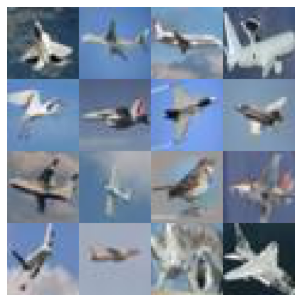

In [50]:
top16 = training_embeds.find(query_doc, limit=16)
top16.plot_image_sprites()

In [42]:
!pip install --upgrade imgaug

     |████████████████████████████████| 948 kB 4.4 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [43]:
from imgaug import augmenters as iaa

randaugment = iaa.RandAugment(n=3, m=7)
rotate = iaa.Affine(rotate=(-45, 45))
crop = iaa.Crop(percent=(0, 0.2))
noise = iaa.AdditiveGaussianNoise(scale=(10, 30))

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81)
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81)


In [45]:
from tensorflow import keras

def get_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_cifar_10()

170508288/170498071 [==============================] - 3s 0us/step


In [46]:
rotated_airplane = rotate(image=x_test[10])
from PIL import Image
im = Image.fromarray(rotated_airplane)
im.save("rotated_airplane_test.jpg")